# Import

In [235]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

pd.options.display.max_rows = 10
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [6]:
user=pd.read_csv('takehome_users.csv', encoding='latin1')
user_eng=pd.read_csv('takehome_user_engagement.csv')

In [57]:
user.head(3)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0


In [13]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [56]:
user_eng.head(3)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1


In [11]:
user_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


#### Check for duplicate rows

In [63]:
duplicate=sum(user.duplicated())
duplicate

0

In [64]:
duplicate=sum(user_eng.duplicated())
duplicate

0

# Identify adopted_user

In [24]:
user_eng['time_stamp']=pd.to_datetime(user_eng['time_stamp'])

In [60]:
# Create a function to check if a user is adopted 
def is_adopted(df):
    login_days = df['time_stamp'].dt.date
    for i in range(len(login_days) - 2):
        if (login_days.iloc[i + 2] - login_days.iloc[i]).days <= 7:
            return 1  # User is adopted
    return 0  # User is not adopted

# Group by user_id and apply the is_adopted function
adopted_users = user_eng.groupby('user_id').apply(is_adopted).reset_index(name='adopted_user')

adopted_users.head()

,user_id,adopted_user
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


In [111]:
adopted_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8823 entries, 0 to 8822
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   user_id       8823 non-null   int64
 1   adopted_user  8823 non-null   int64
dtypes: int64(2)
memory usage: 138.0 KB


# Data Processing

In [279]:
#Merge two dataset
df = pd.merge(user, adopted_users, left_on='object_id', right_on='user_id', how='left').drop('user_id',axis=1)

In [280]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  adopted_user                8823 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 1.0+ MB


The rows that do not have user engagement infomation are definitely not adopted user, so fill the null in the adopted_user with 0. Some values for the last session creation time are null, which means for these users there last session is when they create there account, so we can fill the null value with their creation_time.

In [281]:
#Fill na for the target

df.adopted_user=df.adopted_user.fillna(0)

#Convert Unix timestamp to a datetime object and Format the datetime object
df['last_session_creation_time']=df['last_session_creation_time'].map(lambda data: 
                                    datetime.datetime.utcfromtimestamp(data).strftime('%Y-%m-%d %H:%M:%S'),
                                                                              na_action='ignore')
#Convert object to datetime
df['last_session_creation_time']=pd.to_datetime(df['last_session_creation_time'])

#Fill nas for the last_session_creation_time 
df['last_session_creation_time']=df['last_session_creation_time'].fillna(df['creation_time'])

#Change the data type of adopted_user into int
df['adopted_user']=df['adopted_user'].astype(int)

#Change dtype of createion time
df['creation_time']=pd.to_datetime(df['creation_time'])

#Create a col that divide all the users into two category: invited by other user or not
df['invited_by_user'] = df['invited_by_user_id'].apply(lambda x: 1 if pd.notna(x) else 0)

#Drop the invited_by_user_id col
df=df.drop('invited_by_user_id', axis=1)

Creat a clo that denote the days from user's last session to the latest date

In [282]:
latest_date=df.last_session_creation_time.max()
df['last_session_till_now']=(latest_date-df['last_session_creation_time']).dt.days.astype(int)

Creat a col that stands for how long did the user beening using it.

In [283]:
df['usage_len']=(df['last_session_creation_time']-df['creation_time']).dt.days.astype(int)

Create a new domain col and set domains other than the top 6 as 'other'

In [284]:
# Define a function to extract the domain of email adderss
def extract_domain(email):
    return email.split('@')[1] if '@' in email else None

# Check the top 10 domain
df['domain']=df['email'].apply(extract_domain)

In [285]:
df['domain'].value_counts().head(10)

domain
gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
gustr.com         1179
hotmail.com       1165
rerwl.com            2
oqpze.com            2
qgjbc.com            2
dqwln.com            2
Name: count, dtype: int64

In [286]:
#top 6 domains list
top6_domains = df['domain'].value_counts().index[:6]
df['main_domains']=[x if x in top6_domains else 'other' for x in df['domain']]

In [287]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  12000 non-null  datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   adopted_user                12000 non-null  int64         
 10  invited_by_user             12000 non-null  int64         
 11  last_session_till_now       12000 non-null  int64     

# EDA

In [288]:
df.adopted_user.value_counts()

adopted_user
0    10344
1     1656
Name: count, dtype: int64

Only 13.8% user are adopted user. This dataset is super unbalanced, we may need to resamble later before modeling.

In [289]:
#Define the function:
def adoptrate(col_name,data=df):
    adopt_by_col= data[data.adopted_user==1][col_name].value_counts()
    adoptrate_by_col = adopt_by_col/data[col_name].value_counts()
    return adoptrate_by_col

In [290]:
#Caculate the adopt rate for different categories
cat_features=['creation_source','main_domains','opted_in_to_mailing_list','enabled_for_marketing_drip','invited_by_user']
for col in cat_features:
    print(adoptrate(col,df))

creation_source
GUEST_INVITE          0.170596
ORG_INVITE            0.134932
PERSONAL_PROJECTS     0.081478
SIGNUP                0.144705
SIGNUP_GOOGLE_AUTH    0.172563
Name: count, dtype: float64
main_domains
cuvox.de          0.119800
gmail.com         0.156373
gustr.com         0.127226
hotmail.com       0.175966
jourrapide.com    0.135028
other             0.137437
yahoo.com         0.109113
Name: count, dtype: float64
opted_in_to_mailing_list
0    0.136243
1    0.143287
Name: count, dtype: float64
enabled_for_marketing_drip
0    0.137049
1    0.143415
Name: count, dtype: float64
invited_by_user
1    0.146953
0    0.127709
Name: count, dtype: float64


The adoption rate calculation above reveals variations in adoption rates among various acquisition sources. The highest adoption rate is observed among users who register through Google Authentication, whereas users invited to join someone else's personal workspace exhibit the lowest adoption rate. In terms of domains, Hotmail users have the highest adoption rate. Users who willingly subscribed to marketing emails and received regular email communications show a slightly higher likelihood of retention. Furthermore, users who were invited by their peers are more inclined to become adopted users.

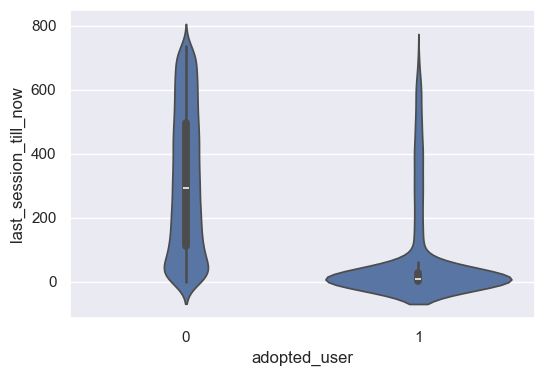

In [291]:
#Plot last_session_till_latest and the target.
plt.figure(figsize=(6, 4))
ax=sns.violinplot(df, x='adopted_user', y='last_session_till_now')

Users who have been adopted are more inclined to have a more recently last session.

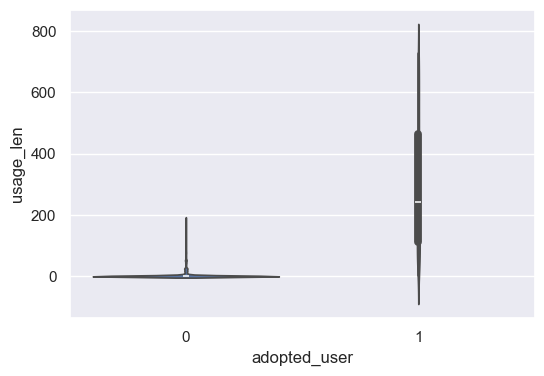

In [292]:
#Plot use_len and the target.
plt.figure(figsize=(6, 4))
ax=sns.violinplot(df, x='adopted_user', y='usage_len')

Adapted users clearly have a longer usage length.

# Modeling & Analysis 

Drop useless columns

In [293]:
df1=df.iloc[:,4:].drop(['last_session_creation_time','domain'], axis=1)

In [294]:
#Feature encoding
df1=pd.get_dummies(df1,columns=['creation_source','main_domains'], dtype=int, drop_first=True)
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df1['org_id_label'] = le.fit_transform(df1['org_id'])
df1=df1.drop('org_id',axis=1)

In [295]:
df1.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted_user,invited_by_user,last_session_till_now,usage_len,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,main_domains_gmail.com,main_domains_gustr.com,main_domains_hotmail.com,main_domains_jourrapide.com,main_domains_other,main_domains_yahoo.com,org_id_label
0,1,0,0,1,45,0,0,0,0,0,0,0,0,0,0,1,11
1,0,0,1,1,67,136,1,0,0,0,0,1,0,0,0,0,1
2,0,0,0,1,443,0,1,0,0,0,0,1,0,0,0,0,94
3,0,0,0,1,380,1,0,0,0,0,0,0,0,0,0,1,1
4,0,0,0,1,500,5,0,0,0,0,0,0,0,0,0,1,193


In [296]:
X=df1.drop('adopted_user', axis=1)
y=df1[['adopted_user']]
from sklearn.model_selection import train_test_split
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=12)

In [297]:

from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(random_state=12, class_weight='balanced_subsample')
rf_model=rf.fit(X_train, y_train)

In [298]:
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error, confusion_matrix, roc_curve, roc_auc_score
y_pred = rf_model.predict(X_test)
y_trainpred = rf_model.predict(X_train)
accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train=accuracy_score(y_train, y_trainpred)
mae_train=mean_absolute_error(y_train, y_trainpred)
mae_test=mean_absolute_error(y_test, y_pred)
report = classification_report(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print("Train Accuracy:",accuracy_train)
print("Test Accuracy:", accuracy_test)
print("Train MAE:",mae_train)
print("Test MAE:", mae_test)
print("Classification Report:\n", report)
print(confusion)

Train Accuracy: 1.0
Test Accuracy: 0.9733333333333334
Train MAE: 0.0
Test MAE: 0.02666666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      3108
           1       0.93      0.87      0.90       492

    accuracy                           0.97      3600
   macro avg       0.96      0.93      0.94      3600
weighted avg       0.97      0.97      0.97      3600

[[3078   30]
 [  66  426]]


This is a excellent model with high accracy, and there is no sign of overfitting issue. This model can predict user adoption accuratly. Let's check it's Feature importance. 

In [299]:
importances = rf_model.feature_importances_
feature_importance=pd.DataFrame({'Feature_Names': X.columns, 'Feature_Importance(%)': importances*100}).sort_values(by='Feature_Importance(%)', ascending=False)

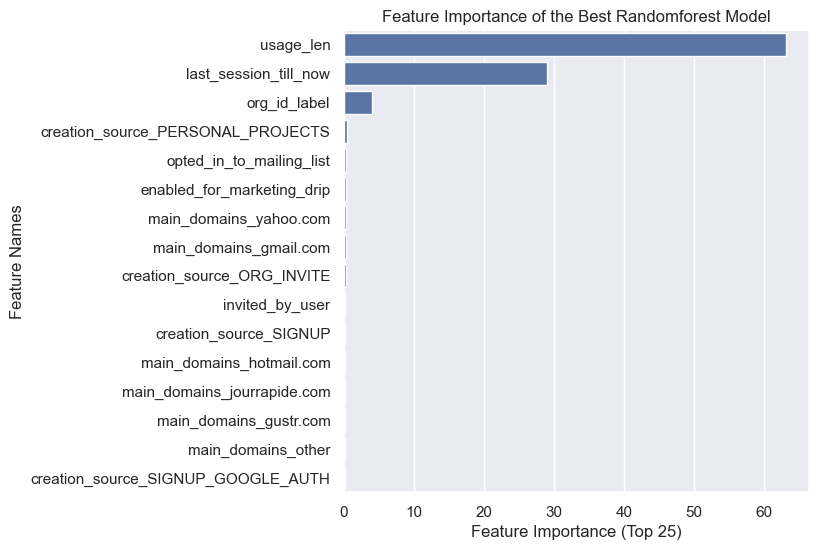

In [300]:
plt.figure(figsize=(6, 6))
sns.set(font_scale=1)
ax=sns.barplot(feature_importance.head(25),
               x='Feature_Importance(%)',
               y='Feature_Names')
plt.xlabel('Feature Importance (Top 25)')
plt.ylabel('Feature Names')
# Add a title
plt.title('Feature Importance of the Best Randomforest Model')
# Show the plot
plt.show()

In [301]:
top10feature_list=feature_importance.head(10).Feature_Names.tolist()
top15feature=pd.concat([X.loc[:,top10feature_list], y], axis=1)

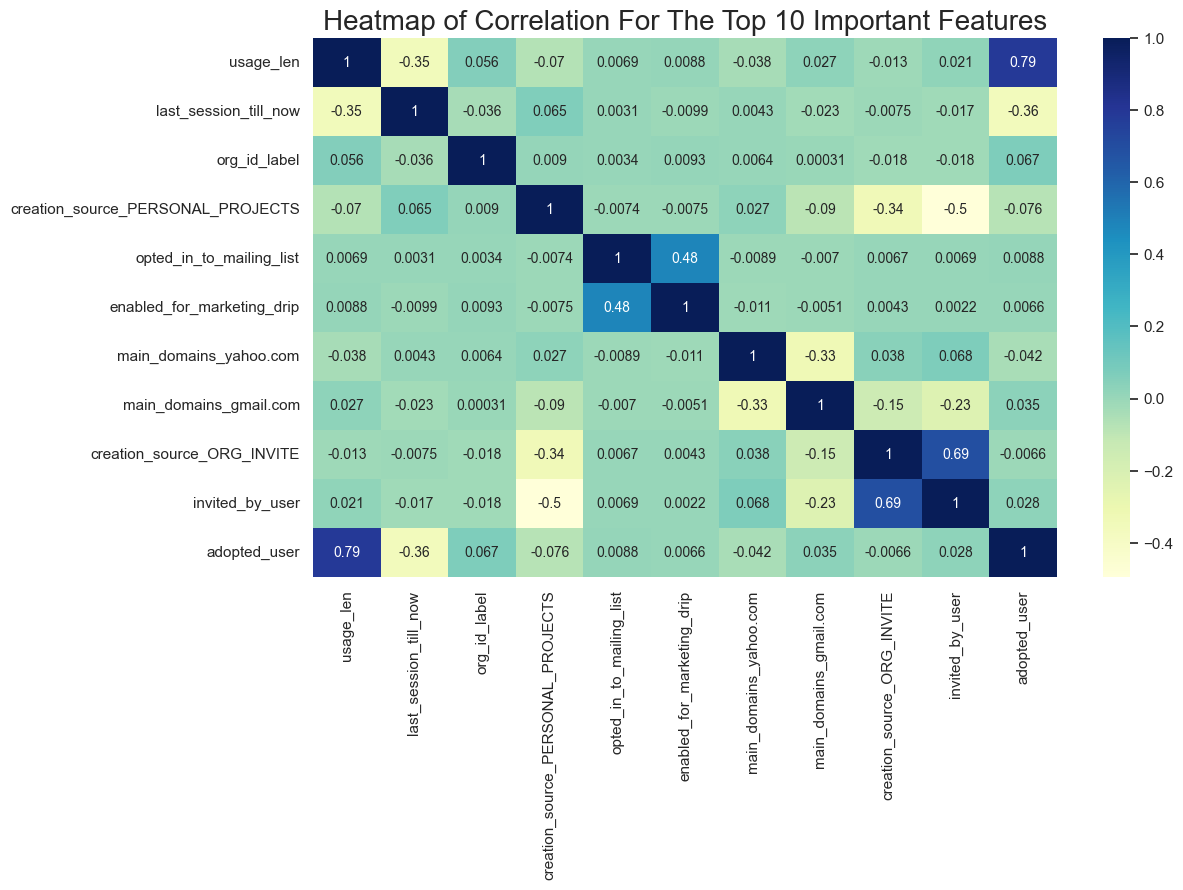

In [302]:
# plotting correlation heatmap 
_ = plt.figure(figsize=(12,7))
_ =sns.heatmap(top15feature.corr(method='pearson'), cmap="YlGnBu", annot=True, annot_kws={'size':10}) 
_ = plt.title('Heatmap of Correlation For The Top 10 Important Features', size=20)

The most crucial feature for this model is the usage length, followed by last_session_till_latest, representing the days between the user's last session and the latest date of data collection. These two features collectively contribute to over 90% of the model's predictive power. The correlation heatmap further emphasizes that users are more likely to be adopted if they use the service for an extended period. Additionally, a more recent last session increases the likelihood of a user being adopted. Beyond these primary contributors, org_id_label also plays a significant role in predicting adopted users, indicating that the organization (group of users) to which individuals belong has an impact on their likelihood of becoming adopted users.